In [4]:
from bs4 import BeautifulSoup
import requests
import os

def main():
    url = "https://news.google.com/news/headlines?ned=in&hl=en-IN&gl=IN"
    data = requests.get(url)
    soup = BeautifulSoup(data.content, "html.parser")
    
    path = r"C:\Users\Vishal-PC\k-means"
    filename = os.path.join(path, 'data\scraped_headlines.txt')
    links = soup.find_all("a")
    with open(filename, 'w', encoding="utf-8") as f:
        for link in links:
            text = link.text
            headline_length = len(text.split())
            if headline_length > 4:
                f.write(text)
                f.write('\n')
            
if __name__ == '__main__':
    main()


In [4]:
import re
from string import punctuation
import os
def main():
    path = r"C:\Users\Vishal-PC\k-means"
    f = open(os.path.join(path, 'data\scraped_headlines.txt'), 'rt', encoding='utf-8') #read in text format
    text_file = f.read().split('\n')
    text_lower = [text.lower() for text in text_file]
    text_letters = [''.join(c for c in s if c not in punctuation)for s in text_lower]
    text_final = [re.sub(r'[^A-Za-z]+',' ', x)for x in text_letters]
    with open(os.path.join(path, 'data\headlines_cleaned.txt'),'w') as fw:
        for text in text_final:
            fw.write(text)
            fw.write('\n')
if __name__ == '__main__':
    main()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterward', 'alon', 'alreadi', 'alway', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becom', 'besid', 'cri', 'describ', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'otherwis', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.

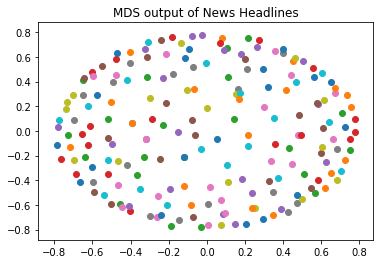

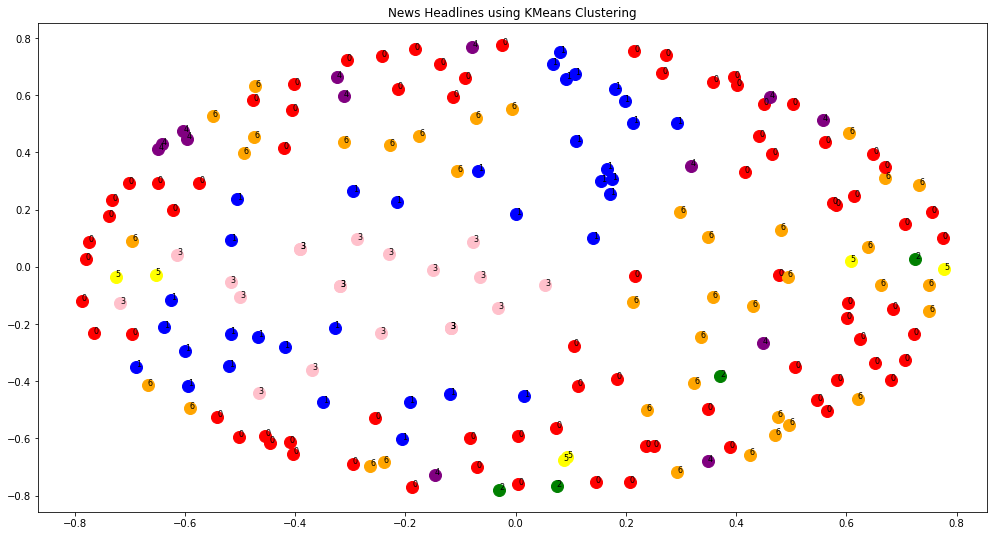

In [5]:
# Tokenize and Stem Data
# Convert words to Vector Space using TFIDF matrix
# Using KMeans clustering to find out clusters
# Calculate Cosine Similarity and generate the distance matrix
# Dimensionality reduction using MDS to results the KMeans output
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import os

path = r"C:\Users\Vishal-PC\k-means"

#path="e://clustring//"
# Tokenizer to return stemmed words, we use this
def tokenize_and_stem(text_file):
    # declaring stemmer and stopwords language
    stemmer = SnowballStemmer("english")
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text_file)
    filtered = [w for w in words if w not in stop_words]
    stems = [stemmer.stem(t) for t in filtered]
    return stems


def main():

    data = pd.read_csv(os.path.join(path, 'data\headlines_cleaned.txt'),names=['text'])

    # text data in dataframe and removing stops words
    stop_words = set(stopwords.words('english'))
    data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # Using TFIDF vectorizer to convert convert words 
    #to Vector Space
    tfidf_vectorizer = TfidfVectorizer(max_features=200000,use_idf=True,
    stop_words='english',tokenizer=tokenize_and_stem)

    # Fit the vectorizer to text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['text'])
    terms = tfidf_vectorizer.get_feature_names()
    # print(terms)

    # Kmeans++
    km = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=1, verbose=0,random_state=34)
    km.fit(tfidf_matrix)
    labels = km.labels_
    clusters = labels.tolist()
 #print(cluster)
    # Calculating the distance measure derived from cosine 
    #similarity
    distance = 1 - cosine_similarity(tfidf_matrix)

    # Dimensionality reduction using Multidimensional 
    #scaling (MDS)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(distance)
    xs, ys = pos[:, 0], pos[:, 1]

    # Saving cluster visualization after mutidimensional scaling
    for x, y, in zip(xs, ys):
        plt.scatter(x, y)
    plt.title('MDS output of News Headlines')
    plt.savefig(os.path.join(path, 'results\MDS.png'))

    # Creating dataframe containing reduced dimensions, 
    #identified labels and text data for plotting 
    #KMeans output
    df = pd.DataFrame(dict(label=clusters, 
                   data=data['text'], x=xs, y=ys))
    df.to_csv(os.path.join(path, 
           'results\kmeans_clustered_DF.txt'), sep=',')

    label_color_map = {0: 'red',
                       1: 'blue',
                       2: 'green',
                       3: 'pink',
                       4: 'purple',
                       5: 'yellow',
                       6: 'orange',
                       7: 'grey'
                       }

    csv = open(os.path.join(path, 'results\kmeans_clustered_output.txt'), 'w')
    csv.write('Cluster     Headline\n')

    fig, ax = plt.subplots(figsize=(17, 9))

    for index, row in df.iterrows():
        cluster = row['label']
        label_color = label_color_map[row['label']]
        label_text = row['data']
        ax.plot(row['x'], row['y'], marker='o', 
        ms=12, c=label_color)
        row = str(cluster) + ',' + label_text + '\n'
        csv.write(row)

    # ax.legend(numpoints=1)
    for i in range(len(df)):
        ax.text(df.ix[i]['x'], df.ix[i]['y'],
        df.ix[i]['label'], size=8)

    plt.title('News Headlines using KMeans Clustering')
    plt.savefig(os.path.join(path, 'results\kmeans.png'))


if __name__ == '__main__':
    main()